## Direct Marketing Optimization
by Nelson Fotzo [nelson.fotzo-simo@edu.dsti.co | femtonelson@gmail.com]<br>

**SUMMARY<br>
I. <a href='#I.-Objective:-Maximize-revenue-from-direct-marketing-campaigns'>Objective</a><br>
II. <a href='#II.-Data-Exploration'>Data Exploration</a><br>
III. <a href='#III.-Propensity-Models'>Propensity Models</a><br>
IV.  <a href='#IV.-Propensity-Prediction-on-Test-Set'>Propensity Prediction on Test Set</a><br>
V. <a href='#V.-Revenue'>Revenue</a><br>
VI. <a href='#VI.-Results'>Results</a><br>
    <a href='#Conclusion'>Conclusion</a>**

# **I. Objective: Maximize revenue from direct marketing campaigns**
**Data:** <br>
- Social-demographical data (age, gender, tenure in a bank) <br>
- Products owned + actual volumes (current account, saving account, mutual funds, overdraft, credit card, consumer loan)<br>
- Inflow/outflow on Current Account, aggregated card turnover (monthly average over past 3 months) <br>
- For 60 % of clients, actual sales + revenues from these are available.

**Conditions:** <br>
- The bank has capacity to contact only 15% of the clients (100 people) with a marketing offer and each client can be targeted only once.<br>

**Steps:** <br>
1. Create an analytical dataset (both training and targeting sets)<br>
2. Develop 3 propensity models (consumer loan, credit card, mutual fund) using training data set<br>
3. Optimize targeting clients with the direct marketing offer to maximize the revenue<br>

**Expected result:** <br>
- Which clients have higher propensity to buy consumer loan?
- Which clients have higher propensity to buy credit card?
- Which clients have higher propensity to buy mutual fund?
- Which clients are to be targeted with which offer?
- What would be the expected revenue?

# **II. Data Exploration**

## II.1 Input Data
- 1615 users with "social-demographical" and "products owned + actual volumes" data
- 1587 users with "inflow/outflow" data
- 969 users iwith Sales_Revenues
- Missing values have been replaced with 'NA'.<br>

## II.2 Data Exploration

In [296]:
# Necessary libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # View all columns in dataframe display
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [297]:
# Read dataset "dmo.csv"
dmo = pd.read_csv("dmo.csv", sep=';')
dmo.head()

,Client,Sex,Age,Tenure,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,84,M,66,235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
1,1139,M,52,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,355,M,43,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,174.485000,NaN,NaN,NaN,NaN,NaN
3,1446,F,46,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,323.645714,NaN,NaN,NaN,NaN,NaN
4,1244,F,34,152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,2392.714643,NaN,NaN,NaN,NaN,NaN


In [298]:
# Features
inflow_outflow = ['VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',\
                           'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',\
                           'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card',\
                           'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']
products_ActBalance = ['Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA',\
                                'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']
soc_dem = ['Sex', 'Age', 'Tenure']
sales = ['Sale_MF', 'Sale_CC', 'Sale_CL']
revenue = ['Revenue_MF', 'Revenue_CC', 'Revenue_CL']

In [299]:
# Feature - Sex
# Convert Sex to numerical values : M to 1 and F to 0 -> There are 856 male customers and 759 female customers.
# 3 missing sex values set as 0
dmo['Sex'] = dmo['Sex'].map(lambda s:1 if s=="M" else 0)
dmo['Sex'].value_counts()

1    856
0    759
Name: Sex, dtype: int64

In [300]:
# Check missing values - Row 0
def dfsummary(df):
    """Function input : A dataframe | 
       Function output : Row 0 - Number of missing values per column, Row 1 - Number of available values per column"""
    return pd.DataFrame([df.isna().sum(), df.count()])

dfsummary(dmo)

,Client,Sex,Age,Tenure,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,0,0,0,0,646,646,646,646,646,646,28,28,28,28,28,28,28,28,28,28,28,28,28,28,0,1189,1309,1196,1445,1480,0,1189,1309,1196,1445,1480
1,1615,1615,1615,1615,969,969,969,969,969,969,1587,1587,1587,1587,1587,1587,1587,1587,1587,1587,1587,1587,1587,1587,1615,426,306,419,170,135,1615,426,306,419,170,135


- There are 28 users with no inflow/outflow data [VolumeCred -> TransactionsDeb_PaymentOrder]. We will consider all their inflow/outflow stats are zero.<br>
- Users with no information on accounts/account balance (their counts match) can be considered as having zero account/zero balance, NA replaced with zero.

In [301]:
# Set inflow/outflow stats for 28 users with no stats as zero.
# For customers with no information on accounts/account balance (their counts match), we set them as zero.
for feature in inflow_outflow + products_ActBalance:
    dmo.loc[dmo[feature].isna(), feature] = 0
    
dfsummary(dmo)

,Client,Sex,Age,Tenure,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,0,0,0,0,646,646,646,646,646,646,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1615,1615,1615,1615,969,969,969,969,969,969,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615


In [302]:
# Age (in years) and Tenure (in months)
# Check customers who have a tenure higher than their age
print("{} customers have a tenure higher than their Age".format(len(dmo[dmo['Age'] < dmo['Tenure']/12])))

# Customers aged less than 15
print("{} customers aged less than 15".format(len(dmo['Age'][dmo['Age'] < 15])))

47 customers have a tenure higher than their Age
76 customers aged less than 15


There are 47 customers with Tenure higher than Age and a significant number of customers aged less than 15. A few questions :<br>
- Could a person become a customer before birth?<br>
- Can customers less than 15 years old for example, buy a consumer loan or credit card or mutual fund ?<br>
In the absence of additional information, we will keep these users and proceed with the study. 

### Inflow/Outflow features

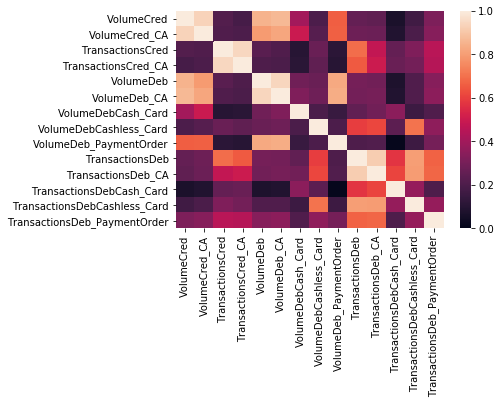

In [303]:
# Correlation map
sns.heatmap(dmo[inflow_outflow].corr(), vmin=0, vmax=1)

There's a strong correlation between the following feature pairs : (VolumeCred, VolumeCred_CA), (VolumeDeb, VolumeDeb_CA),
(TransactionsCred, TransactionsCred_SA), (TransactionsDeb, TransactionsDeb_CA) and a closer look at the data description shows there is linear relation(or causality) between these feature pairs. In fact, the first feature (i.e total volume) of each pair is the sum of the second (i.e by current account) and other features (ie by cash card, cashless card and payment order).
We choose to : <br>
**- Discard VolumeCred, VolumeDeb, TransactionsCred & TransactionsDeb, as they convey no additional information.**<br>

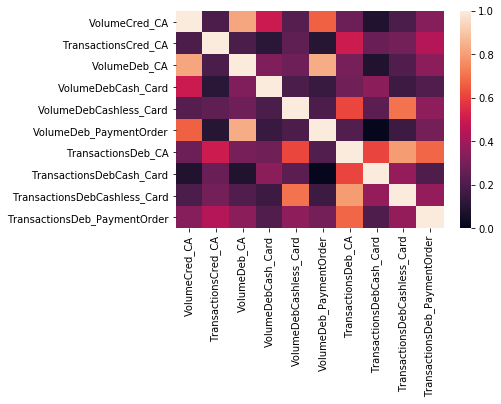

In [304]:
# Update the list of useful inflow/outflow features
inflow_outflow = ['VolumeCred_CA', 'TransactionsCred_CA', 'VolumeDeb_CA', 'VolumeDebCash_Card',\
                  'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA',\
                  'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']
sns.heatmap(dmo[inflow_outflow].corr(), vmin=0, vmax=1)

Also :<br> 
- VolumeCred_CA and VolumeDeb_CA are strongly correlated (0.83). This suggests a linear relationship which can be explained by the fact that the higher the volume of credits received by a customer in his/her current account, the higher the volume of debits he/she is likely to make. 
- TransactionsDebCashless_Card and TransactionsDeb_CA have a correlation of 0.79. This is likely because the majority of debit transactions on current account are cashless debits via card.<br><br>
**There is a correlation but also a causal relation between these variables.**

We choose to : <br>
- Create **a new feature "NetCA_flow" - the net cass flow on the current account** : NetCA_flow = VolumeCred_CA - VolumeDeb_CA and **discard both features : VolumeCred_CA, VolumeDeb_CA**<br>
- **Discard the feature TransactionsDebCashless_Card** and keep only TransactionsDeb_CA.

In [305]:
dmo = dmo.assign(NetCA_flow = dmo['VolumeCred_CA'] - dmo['VolumeDeb_CA'])

# Update the list of useful inflow/outflow features
inflow_outflow = ['NetCA_flow', 'TransactionsCred_CA', 'VolumeDebCash_Card', \
                  'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA',\
                  'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder']

### Other Features

In [306]:
dmo[sales + products_ActBalance + soc_dem + inflow_outflow].corr()

,Sale_MF,Sale_CC,Sale_CL,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,Sex,Age,Tenure,NetCA_flow,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder
Sale_MF,1.000000,-0.019104,-0.009934,0.003675,-0.001527,0.164993,-0.005856,0.000740,-0.044909,-0.042985,-0.036163,0.026076,0.000470,0.012711,-0.052701,0.048806,-0.030449,-0.006277,0.080920,0.088573,-0.027537,0.005859,-0.010645,0.062577,0.005351,0.030198
Sale_CC,-0.019104,1.000000,-0.017832,-0.031168,0.106517,-0.027281,0.045248,-0.011060,-0.059801,0.166340,0.176878,-0.027145,-0.024696,-0.025465,-0.047384,-0.007726,0.049301,0.017929,-0.083292,0.006586,-0.009669,-0.013792,0.077699,-0.011107,0.065856,-0.011693
Sale_CL,-0.009934,-0.017832,1.000000,0.084619,0.036352,0.045515,0.040541,-0.013643,0.054304,-0.054026,-0.043773,0.074075,0.067968,-0.074098,0.052295,-0.032190,-0.175752,0.177345,-0.076735,0.092394,0.018157,0.041211,0.053348,0.074017,0.082213,0.057079
Count_CA,0.003675,-0.031168,0.084619,1.000000,0.009560,-0.033410,0.004458,-0.002233,0.012466,-0.007420,-0.005570,0.017510,-0.006251,0.023887,0.017184,0.036094,0.052570,0.033181,0.002075,0.014597,-0.019893,0.005097,0.021343,0.028392,0.012969,0.027467
Count_SA,-0.001527,0.106517,0.036352,0.009560,1.000000,0.169041,-0.012305,0.091321,-0.088444,0.041334,0.326809,0.084164,0.000564,0.003541,-0.064189,-0.057773,0.043782,0.019438,-0.018672,-0.027903,0.017678,0.061379,0.061694,0.004000,-0.057910,0.094417
Count_MF,0.164993,-0.027281,0.045515,-0.033410,0.169041,1.000000,-0.059220,-0.013361,-0.043803,-0.003658,0.132417,0.110401,-0.024142,-0.014411,-0.021996,0.013631,-0.029561,0.002134,-0.041005,-0.011251,0.024066,0.023571,0.037586,0.025517,-0.044898,0.053659
Count_OVD,-0.005856,0.045248,0.040541,0.004458,-0.012305,-0.059220,1.000000,0.211254,0.135062,-0.014212,-0.043685,0.006895,0.351074,0.154864,0.111253,0.019578,0.011297,-0.009631,0.020070,0.408473,0.020750,0.078385,0.021290,0.227426,0.115783,0.244134
Count_CC,0.000740,-0.011060,-0.013643,-0.002233,0.091321,-0.013361,0.211254,1.000000,0.202240,-0.010057,-0.016475,-0.006222,0.082121,0.565010,0.120567,0.003617,0.039677,-0.009351,0.024437,0.185959,0.030654,0.231718,0.086991,0.197196,0.130675,0.262861
Count_CL,-0.044909,-0.059801,0.054304,0.012466,-0.088444,-0.043803,0.135062,0.202240,1.000000,0.013937,-0.038219,0.001895,0.072199,0.101482,0.660240,0.035063,0.019084,0.003957,-0.001365,0.222926,0.030920,0.037052,-0.007126,0.146953,0.077172,0.142816
ActBal_CA,-0.042985,0.166340,-0.054026,-0.007420,0.041334,-0.003658,-0.014212,-0.010057,0.013937,1.000000,0.004166,-0.002352,-0.021083,-0.009586,0.006503,0.007362,-0.006736,0.016695,-0.016871,0.056378,-0.013440,0.021949,-0.005035,0.022023,0.004690,-0.009445


We observe correlations values in the interval -0.2 to 0.2 between Sale variables and features like : Tenure, Age, ActBal_CA, Act_Bal_SA, Count_MF, Count_SA which suggest we should attempt to build a model to predict propensity or probability.

### Data Split Into Train and Test Sets

In [307]:
# Split dataset into training (969 users with non-missing sale and revenue values) and testing set (646 users)
dmo_train = dmo[~dmo['Sale_MF'].isna()]
dmo_test = dmo[dmo['Sale_MF'].isna()]

dfsummary(dmo_train)

,Client,Sex,Age,Tenure,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,NetCA_flow
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969,969


Users in the training dataset either :
- Bought a given product - Sale_MF or Sale_CC or Sale_CL = 1 and generated some revenue - Revenue_MF or Revenue_CC or Revenue_CL > 0<br>or<br>
- Did not buy a product - Sale_MF or Sale_CC or Sale_CL = 0 so null revenue - Revenue_MF or Revenue_CC or Revenue_CL = 0

In [308]:
dfsummary(dmo_test)

,Client,Sex,Age,Tenure,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,NetCA_flow
0,0,0,0,0,646,646,646,646,646,646,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,646,646,646,646,0,0,0,0,0,0,646,646,646,646,646,646,646,646,646,646,646,646,646,646,646,646,646,646,646,646,646,646,646,646,646,646,646


Users in the test dataset did not buy any product in the data collection period and are possible targets for the marketing campaign :
- Sale_MF, Sale_CC, Sale_CL, Revenue_MF, Revenue_CC, Revenue_CL blank.

## II.3 Data Preparation For Modelling

In [309]:
# Statistics
dmo_train[inflow_outflow + products_ActBalance + soc_dem + sales + revenue].describe()

,NetCA_flow,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,Sex,Age,Tenure,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
count,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000
mean,-21.677561,4.216718,265.861413,154.800184,705.984050,13.564499,1.981424,4.543860,1.075335,0.323013,0.983488,0.259030,0.113519,0.090815,2493.026329,3945.675945,4035.177283,38.153711,31.888477,322.249490,0.531476,42.983488,100.393189,0.199174,0.249742,0.299278,1.925015,2.712827,3.604220
std,2662.435331,4.908721,866.245556,330.898970,3070.520579,13.016210,2.698267,5.225334,0.323815,0.578450,4.547015,0.438328,0.317390,0.318195,6268.027982,18207.655212,34790.633953,176.465581,154.547698,1545.704566,0.499266,18.578951,65.437097,0.399586,0.433087,0.458178,9.943601,17.693433,7.743618
min,-35604.112853,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.479286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-107.321071,2.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.135000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,74.281429,23.820357,171.964286,10.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,536.951429,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,41.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,114.653572,4.000000,353.571429,181.307143,483.178571,19.000000,3.000000,7.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2262.178929,0.395714,0.000000,0.000000,0.000000,0.000000,1.000000,57.000000,151.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.642857
max,53935.488930,48.000000,23571.428570,3637.616786,61955.103930,83.000000,25.000000,34.000000,4.000000,3.000000,79.000000,1.000000,1.000000,2.000000,74934.956070,389883.830700,761235.504300,2055.325357,1767.785357,17300.489640,1.000000,90.000000,271.000000,1.000000,1.000000,1.000000,220.488214,407.962500,133.275357


The statistics show the features have varying scales, some with a high standard deviation compared to their mean and some features with much higher numerical values compared to other features. Such differences can bias modelling algorithms and affect model performance. It is necessary to normalize problematic features, typically transaction/account amounts so that their final values follow a normal distribution.

In [ ]:
features_to_normalize = ['NetCA_flow', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',\
                         'VolumeDeb_PaymentOrder', 'ActBal_CA', 'ActBal_SA',\
                         'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']
for feature in features_to_normalize:
    dmo_train.loc[:, feature] = (dmo_train.loc[:, feature] - dmo_train.loc[:, feature].mean())/dmo_train.loc[:, feature].std()

dmo_train[inflow_outflow + products_ActBalance + soc_dem + sales + revenue].describe()

## II.4 Variable Selection Using RandomForest for Propensity models
We have a training dataset of high dimensionality (more than 20 features). To simplify our model, save computation time and simplify the data pipeline to be used by the model in a deployment scenario, it is necessary to find an approach to reduce the number of features for modelling however without losing relevant information.<br>

RandomForest is a popular and efficient algorithm, which uses ensemble learning for classification and regression. 
It combines several binary decision trees built using several bootstrap samples coming from a training dataset and chooses randomly at each node a subset of explanatory variables. The subset of variables is chosen randomly and the best possible split is calculated. No pruning step is performed (as in CART trees) so all the trees of the forest are maximal trees.<br>

The importance a feature in a RandomForest tree is calculated as the sum of the importances of the nodes on which a split on this feature was done divided by the sum of importances of all nodes. This is followed by normalization using the importance of other features and averaging over all trees in the forest.

RandomForestCalssifier of sklearn library is used in this excercise to evaluate relative feature importance and reduce our dataset's dimensionality with a suitable variable importance threshold.

In [311]:
# Evaluate feature importances with RandomForest
all_features = inflow_outflow + products_ActBalance + soc_dem

rfmf = RandomForestClassifier(n_estimators=500, random_state=50)
rfcc = RandomForestClassifier(n_estimators=500, random_state=50)
rfcl = RandomForestClassifier(n_estimators=500, random_state=50)

rfmf.fit(dmo_train[all_features], dmo_train[["Sale_MF"]].to_numpy().ravel())
rfcc.fit(dmo_train[all_features], dmo_train[["Sale_CC"]].to_numpy().ravel())
rfcl.fit(dmo_train[all_features], dmo_train[["Sale_CL"]].to_numpy().ravel())

mf_feature_importances = rfmf.feature_importances_
cc_feature_importances = rfcc.feature_importances_
cl_feature_importances = rfcl.feature_importances_

mf_indices = np.argsort(mf_feature_importances)
cc_indices = np.argsort(cc_feature_importances)
cl_indices = np.argsort(cl_feature_importances)

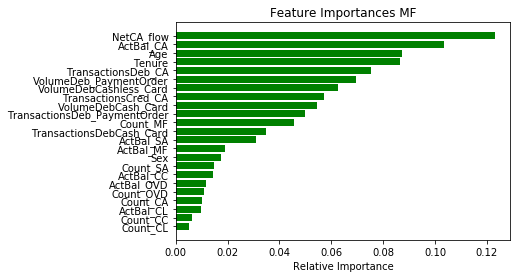

In [312]:
# Plot feature importances for MF
plt.title('Feature Importances MF')
plt.barh(range(len(mf_indices)), mf_feature_importances[mf_indices], color='g', align='center')
plt.yticks(range(len(mf_indices)), [all_features[i] for i in mf_indices])
plt.xlabel('Relative Importance')
plt.show()

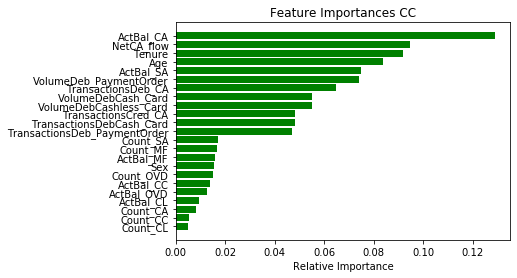

In [313]:
# Plot feature importances for CC
plt.title('Feature Importances CC')
plt.barh(range(len(cc_indices)), cc_feature_importances[cc_indices], color='g', align='center')
plt.yticks(range(len(cc_indices)), [all_features[i] for i in cc_indices])
plt.xlabel('Relative Importance')
plt.show()

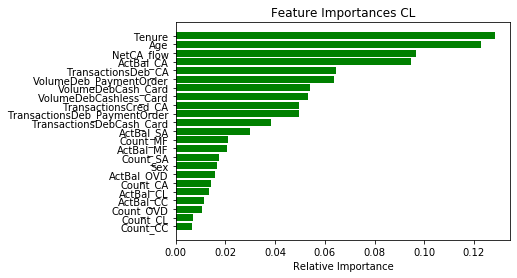

In [314]:
# Plot feature importances for CL
plt.title('Feature Importances CL')
plt.barh(range(len(cl_indices)), cl_feature_importances[cl_indices], color='g', align='center')
plt.yticks(range(len(cl_indices)), [all_features[i] for i in cl_indices])
plt.xlabel('Relative Importance')
plt.show()

Using above plots, we can choose reasonable thresholds for feature selection and significantly reduce the dimensions of our training set for each propensity model.

In [315]:
# Select features using SelectFromModel
def rf_select_features(sale_model, sale_var, thresh):
    sel_var = SelectFromModel(sale_model, threshold=thresh)
    
    input_data = dmo_train[all_features]
    response = np.array(dmo_train[[sale_var]])
    
    sel_var.fit(input_data, response.ravel())
    selected_features = list(input_data.columns[(sel_var.get_support())])
    return selected_features

# Variable importance threshold for MF = 0.02
# Variable importance threshold for CC = 0.02
# Variable importance threshold for CL = 0.02

salemf_features = rf_select_features(rfmf, 'Sale_MF', 0.02)
salecc_features = rf_select_features(rfcc, 'Sale_CC', 0.02)
salecl_features = rf_select_features(rfcl, 'Sale_CL', 0.02)

print("Selected MF features are : {},\nSelected CC features are : {},\nSelected CL features are : {}".\
      format(salemf_features, salecc_features, salecl_features))

Selected MF features are : ['NetCA_flow', 'TransactionsCred_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder', 'Count_MF', 'ActBal_CA', 'ActBal_SA', 'Age', 'Tenure'],
Selected CC features are : ['NetCA_flow', 'TransactionsCred_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder', 'ActBal_CA', 'ActBal_SA', 'Age', 'Tenure'],
Selected CL features are : ['NetCA_flow', 'TransactionsCred_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder', 'Count_MF', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'Age', 'Tenure']


The RandomForest-based variable selection procedure results in different features selected for predicting each target sale 
variable. <br><br>**An interesting remark is that Count_MF(the number of live mutual funds owned by a customer) is more important in the mutual fund propensity model than in the Credit Card model. In order words, the number of mutual funds owned by a customer affects the customer's suceptibility to buy another one.**

**Distribution of Response/Target Variables**

In [316]:
dmo_train.Sale_MF.value_counts()

0.0    776
1.0    193
Name: Sale_MF, dtype: int64

In [317]:
dmo_train.Sale_CC.value_counts()

0.0    727
1.0    242
Name: Sale_CC, dtype: int64

In [318]:
dmo_train.Sale_CL.value_counts()

0.0    679
1.0    290
Name: Sale_CL, dtype: int64

There are many more users who did not buy products compared to those who bought. Such data distribution potentially skews a model's ability to distinguish between classes 1 and 0 given that a correct classification for "0" is not more important than a correct classification for "1". It is necessary to balance the dataset to maximize modeling performance by downsampling the available data.

In [319]:
# Training datasets for three propensity models
dmo_train_MF = dmo_train[['Sale_MF']+salemf_features]
dmo_train_CC = dmo_train[['Sale_CC']+salecc_features]
dmo_train_CL = dmo_train[['Sale_CL']+salecl_features]

# Subset only the customers who bought products
dmo_train_MF_boughtonly = dmo_train_MF.loc[dmo_train_MF['Sale_MF'] == 1]
dmo_train_CC_boughtonly = dmo_train_CC.loc[dmo_train_CC['Sale_CC'] == 1]
dmo_train_CL_boughtonly = dmo_train_CL.loc[dmo_train_CL['Sale_CL'] == 1]

# Sample the customers who did not buy products to be the same number as those who bought
dmo_train_MF_didntbuyonly = dmo_train_MF.loc[dmo_train_MF['Sale_MF'] == 0].sample(len(dmo_train_MF_boughtonly),
                                                                                  random_state=10)
dmo_train_CC_didntbuyonly = dmo_train_CC.loc[dmo_train_CC['Sale_CC'] == 0].sample(len(dmo_train_CC_boughtonly),
                                                                                  random_state=10)
dmo_train_CL_didntbuyonly = dmo_train_CL.loc[dmo_train_CL['Sale_CL'] == 0].sample(len(dmo_train_CL_boughtonly),
                                                                                  random_state=10)

# Concatenate the dataframes "boughtonly" and "didntbuyonly"
dmo_train_MF = pd.concat([dmo_train_MF_boughtonly, dmo_train_MF_didntbuyonly])
dmo_train_CC = pd.concat([dmo_train_CC_boughtonly, dmo_train_CC_didntbuyonly])
dmo_train_CL = pd.concat([dmo_train_CL_boughtonly, dmo_train_CL_didntbuyonly])

**Downsampling of training dataset**

**Result after downsampling**

In [320]:
dmo_train_MF.Sale_MF.value_counts()

0.0    193
1.0    193
Name: Sale_MF, dtype: int64

In [321]:
dmo_train_CC.Sale_CC.value_counts()

0.0    242
1.0    242
Name: Sale_CC, dtype: int64

In [322]:
dmo_train_CL.Sale_CL.value_counts()

0.0    290
1.0    290
Name: Sale_CL, dtype: int64

In [323]:
# Stratify to ensure same distribution of both classes in training and validation
# Split training datasets for training and validation - Full dataset
X_mf_f, X_cc_f, X_cl_f = dmo_train[salemf_features], dmo_train[salecc_features], dmo_train[salecl_features]
Y_mf_f, Y_cc_f, Y_cl_f = dmo_train['Sale_MF'], dmo_train['Sale_CC'], dmo_train['Sale_CL']

X_trainmf_f, X_valmf_f, Y_trainmf_f, Y_valmf_f = train_test_split(X_mf_f, Y_mf_f, test_size=0.2, random_state = 20, stratify=Y_mf_f)
X_traincc_f, X_valcc_f, Y_traincc_f, Y_valcc_f = train_test_split(X_cc_f, Y_cc_f, test_size=0.2, random_state = 20, stratify=Y_cc_f)
X_traincl_f, X_valcl_f, Y_traincl_f, Y_valcl_f = train_test_split(X_cl_f, Y_cl_f, test_size=0.2, random_state = 20, stratify=Y_cl_f)


# Split training datasets for training and validation - Downsampled dataset
X_mf, X_cc, X_cl = dmo_train_MF[salemf_features], dmo_train_CC[salecc_features], dmo_train_CL[salecl_features]
Y_mf, Y_cc, Y_cl = dmo_train_MF['Sale_MF'], dmo_train_CC['Sale_CC'], dmo_train_CL['Sale_CL']

X_trainmf, X_valmf, Y_trainmf, Y_valmf = train_test_split(X_mf, Y_mf, test_size=0.2, random_state = 20, stratify=Y_mf)
X_traincc, X_valcc, Y_traincc, Y_valcc = train_test_split(X_cc, Y_cc, test_size=0.2, random_state = 20, stratify=Y_cc)
X_traincl, X_valcl, Y_traincl, Y_valcl = train_test_split(X_cl, Y_cl, test_size=0.2, random_state = 20, stratify=Y_cl)

# III. Propensity Models 
The models chosen here are of type Mutli Layer Perceptron(MLP) neural network with 1 or more hidden layers. MLPs provide a good accuracy in many scenarios. The gradient descent algorithm is Adam and the loss function to be minimized by the neural network is binary cross entropy, suitable for this binary classification problem where we predict probability using a sigmoid function in the output layer. Due to the stochastic behaviour of the training algorithm, it is necessary to train the neural network several times until an acceptable accuracy is obtained.

## III.1 Mutual Fund Model
Predicts the probability of a customer to buy a Mutual Fund

In [211]:
def trainval_MF(X_train, Y_train, X_val, Y_val):
    # lr varied betwen 0.01 and 0.0005 to get best model
    # Number of deep layers varied between 1 and 3 to get the best model
    # Dropout and BatchNormalization did not improve results
    # Sale MF model
    sale_mf = Sequential()
    sale_mf.add(Dense(8, activation='relu', input_shape=(len(salemf_features),)))
    sale_mf.add(Dense(15, activation='relu'))
    sale_mf.add(Dense(1, activation='sigmoid'))
    sale_mf.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping_monitor = EarlyStopping(patience=20)
    training = sale_mf.fit(X_train, Y_train, validation_data=(X_val, Y_val),\
                           epochs=2000, verbose=False, callbacks=[early_stopping_monitor])

    sale_mf_history = training.history

    fig, ax = plt.subplots()
    ax.plot(sale_mf_history['loss'], 'r', label='Training loss vs Epochs')
    ax.plot(sale_mf_history['val_loss'], 'b', label='Validation loss vs Epochs')
    ax.legend()
    plt.show()
    print("Final validation loss : {}, Final validation accuracy : {}"\
          .format(round(sale_mf_history['val_loss'][-1],3), round(sale_mf_history['val_accuracy'][-1],3)))
    
    return sale_mf

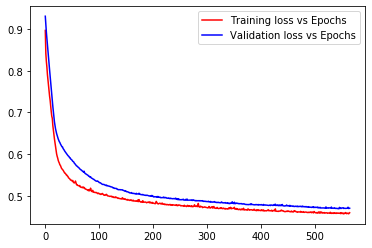

Final validation loss : 0.47, Final validation accuracy : 0.799


In [237]:
# Training and validation - Full dataset
sale_mf_f = trainval_MF(X_trainmf_f, Y_trainmf_f, X_valmf_f, Y_valmf_f)

In [241]:
# AUC Score - Full dataset
roc_auc_score(Y_valmf_f, sale_mf_f.predict(X_valmf_f))

0.6770885028949545

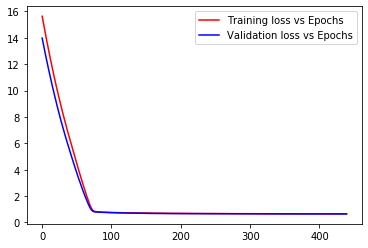

Final validation loss : 0.65, Final validation accuracy : 0.641


In [239]:
# Training and validation - Balanced dataset
sale_mf = trainval_MF(X_trainmf, Y_trainmf, X_valmf, Y_valmf)

In [242]:
# AUC Score - Balanced dataset
roc_auc_score(Y_valmf, sale_mf.predict(X_valmf))

0.6936226166995398

**A higher validation accuracy is achieved with the full dataset(80%) compared with the balanced dataset(64%) meanwhile both AUC scores are almost the same, with more accuracy/AUC score fluctuation observed from one training to another for the balanced dataset. This suggests the balanced dataset may not have enough patterns to model as it is significantly smaller. A bigger balanced dataset is necessary to improve modeling accuracy.**

## III.2 Credit Card Model
Predicts the probability of a customer to buy a Credit Card

In [263]:
def trainval_CC(X_train, Y_train, X_val, Y_val):
    # lr varied betwen 0.01 and 0.0005 to get best model
    # Number of deep layers varied between 1 and 3 to get the best model
    # Dropout and BatchNormalization did not improve results
    # Sale CC model
    sale_cc = Sequential()
    sale_cc.add(Dense(12, activation='relu', input_shape=(len(salecc_features),)))
    sale_cc.add(Dense(15, activation='relu'))
    sale_cc.add(Dense(1, activation='sigmoid'))
    sale_cc.compile(optimizer=Adam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping_monitor = EarlyStopping(patience=10)
    training = sale_cc.fit(X_train, Y_train, validation_data=(X_val, Y_val),\
                           epochs=1000, verbose=False, callbacks=[early_stopping_monitor])

    sale_cc_history = training.history

    fig, ax = plt.subplots()
    ax.plot(sale_cc_history['loss'], 'r', label='Training loss vs Epochs')
    ax.plot(sale_cc_history['val_loss'], 'b', label='Validation loss vs Epochs')
    ax.legend()
    plt.show()
    print("Final validation loss : {}, Final validation accuracy : {}"\
          .format(round(sale_cc_history['val_loss'][-1],3), round(sale_cc_history['val_accuracy'][-1],3)))
    
    return sale_cc 

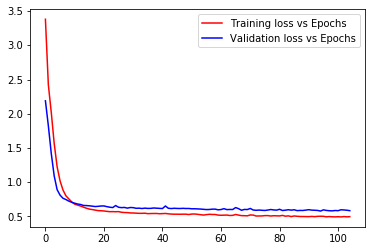

Final validation loss : 0.585, Final validation accuracy : 0.768


In [256]:
# Training and validation - Full dataset
sale_cc_f = trainval_CC(X_traincc_f, Y_traincc_f, X_valcc_f, Y_valcc_f)

In [257]:
# AUC Score - Full dataset
roc_auc_score(Y_valcc_f, sale_cc_f.predict(X_valcc_f))

0.545376712328767

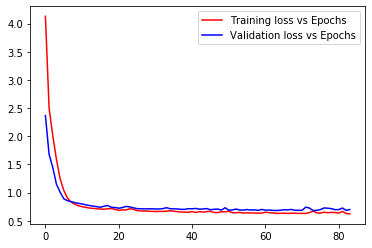

Final validation loss : 0.699, Final validation accuracy : 0.557


In [259]:
# Training and validation - Balanced dataset
sale_cc = trainval_CC(X_traincc, Y_traincc, X_valcc, Y_valcc)

In [260]:
# AUC Score - Balanced dataset
roc_auc_score(Y_valcc, sale_cc.predict(X_valcc))

0.5752551020408163

Similarly to MF propensity modelling, the balanced dataset has a slightly better AUC score but lower validation accuracy.

## III.3 Customer Loan Model
Predicts the probability of a customer to buy a Customer Loan

In [267]:
def trainval_CL(X_train, Y_train, X_val, Y_val): 
    # lr varied betwen 0.01 and 0.0005 to get best model
    # Number of deep layers varied between 1 and 3 to get the best model
    # Dropout and BatchNormalization did not improve results
    # Sale CL model
    sale_cl = Sequential()
    sale_cl.add(Dense(15, activation='relu', input_shape=(len(salecl_features),)))
    sale_cl.add(Dense(15, activation='relu'))
    sale_cl.add(Dense(1, activation='sigmoid'))
    sale_cl.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping_monitor = EarlyStopping(patience=50)
    training = sale_cl.fit(X_train, Y_train, validation_data=(X_val, Y_val),\
                           epochs=1000, verbose=False, callbacks=[early_stopping_monitor])

    sale_cl_history = training.history

    fig, ax = plt.subplots()
    ax.plot(sale_cl_history['loss'], 'r', label='Training loss vs Epochs')
    ax.plot(sale_cl_history['val_loss'], 'b', label='Validation loss vs Epochs')
    ax.legend()
    plt.show()
    print("Final validation loss : {}, Final validation accuracy : {}"\
          .format(round(sale_cl_history['val_loss'][-1],3), round(sale_cl_history['val_accuracy'][-1],3)))
    
    return sale_cl

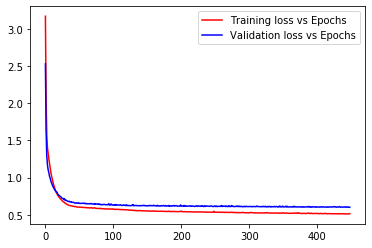

Final validation loss : 0.601, Final validation accuracy : 0.716


In [270]:
# Training and validation - Full dataset
sale_cl_f = trainval_CL(X_traincl_f, Y_traincl_f, X_valcl_f, Y_valcl_f)

In [271]:
# AUC Score - Full dataset
roc_auc_score(Y_valcl_f, sale_cl_f.predict(X_valcl_f))

0.654792089249493

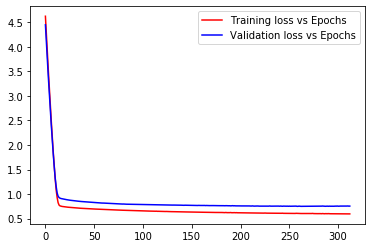

Final validation loss : 0.756, Final validation accuracy : 0.569


In [276]:
# Training and validation - Balanced dataset
sale_cl = trainval_CL(X_traincl, Y_traincl, X_valcl, Y_valcl)

In [277]:
# AUC Score - Balanced dataset
roc_auc_score(Y_valcl, sale_cl.predict(X_valcl))

0.5639120095124851

The Consumer Loan (CL) propensity modelling performed on full dataset gives a better accuracy and AUC score than the balanced dataset. The balanced dataset is likely too small to boost modelling performance.

# IV. Propensity Prediction on Test Set

The models obtained on full dataset are used here.

## IV.1 Test Data Preparation

In [350]:
# Feature Normalization
features_to_normalize = ['NetCA_flow', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',\
                         'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']

for feature in features_to_normalize:
    dmo_test.loc[:, feature] = (dmo_test.loc[:, feature] - dmo_test.loc[:, feature].mean())/dmo_test.loc[:, feature].std()

dmo_test[inflow_outflow + products_ActBalance + soc_dem + sales + revenue].describe()

## IV.2 Sale_MF, Sale_CC, Sale_CL Propensity Prediction

In [ ]:
# Predict Sale_MF, Sale_CC and Sale_CL probabilities for the test set, and fill the values into dmo_test dataframe
dmo_test.loc[:, 'Sale_MF'] = sale_mf_f.predict(dmo_test[salemf_features])
dmo_test.loc[:, 'Sale_CC'] = sale_cc_f.predict(dmo_test[salecc_features])
dmo_test.loc[:, 'Sale_CL'] = sale_cl_f.predict(dmo_test[salecl_features])
dmo_test

# V. Revenue

The objective is to study the potential revenue which could be made from a marketing campaign targeting customers identified 
as having a high propensity/susceptibility.

In [327]:
dmo_train[revenue + inflow_outflow + products_ActBalance + soc_dem].corr()

,Revenue_MF,Revenue_CC,Revenue_CL,NetCA_flow,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,Sex,Age,Tenure
Revenue_MF,1.000000,-0.019050,-0.010353,0.101062,0.026941,-0.019111,-0.018841,-0.009977,-0.018049,-0.024776,-0.003617,0.001831,0.013629,0.037467,0.049337,0.005592,-0.030744,0.004011,-0.024455,0.004617,-0.014380,-0.011664,-0.023351,0.044636,0.046147,-0.007787
Revenue_CC,-0.019050,1.000000,0.016695,-0.003072,0.018303,-0.011033,-0.016994,0.050268,0.025686,0.038925,0.022651,-0.021852,0.011455,-0.006240,0.084483,-0.002629,-0.024726,0.009105,0.004424,-0.011111,-0.022585,0.007251,-0.018056,-0.037160,0.027300,0.000168
Revenue_CL,-0.010353,0.016695,1.000000,-0.101176,0.036115,0.011394,0.010896,0.056169,0.020615,0.041668,0.012453,0.059230,0.045696,0.025940,0.016429,-0.045292,0.055348,-0.023128,0.023288,0.085097,0.037555,-0.070986,0.042403,-0.023253,-0.130591,0.167014
NetCA_flow,0.101062,-0.003072,-0.101176,1.000000,0.006619,0.532830,-0.068725,-0.197446,0.026141,0.064142,0.019382,0.007008,-0.041170,-0.055723,0.019426,0.020558,0.006948,-0.008678,-0.267846,-0.003179,0.007877,0.005007,0.017823,0.004235,-0.039674,-0.023054
TransactionsCred_CA,0.026941,0.018303,0.036115,0.006619,1.000000,0.108700,0.263789,0.122438,0.501023,0.278437,0.422362,0.015065,-0.048692,-0.011920,0.454491,0.196377,0.222844,0.121346,-0.031087,0.055329,0.163871,0.112353,0.126024,0.062129,0.034396,-0.033765
VolumeDebCash_Card,-0.019111,-0.011033,0.011394,0.532830,0.108700,1.000000,0.188514,0.211283,0.281088,0.329414,0.212751,-0.028833,0.002113,0.007276,0.024626,0.027026,0.019363,-0.010538,0.002825,-0.003926,-0.006799,0.011670,0.005749,0.029459,0.011285,-0.004886
VolumeDebCashless_Card,-0.018841,-0.016994,0.010896,-0.068725,0.263789,0.188514,1.000000,0.240939,0.618900,0.229898,0.367026,-0.037337,0.061887,0.008286,0.072391,0.191106,0.038466,0.054955,-0.003499,0.017542,0.042480,0.108803,0.015122,0.007066,0.030436,0.010247
VolumeDeb_PaymentOrder,-0.009977,0.050268,0.056169,-0.197446,0.122438,0.211283,0.240939,1.000000,0.218838,0.008285,0.321785,-0.032562,0.033910,0.045747,0.037751,0.100961,-0.029353,-0.021040,0.175644,-0.002724,-0.016724,0.092930,-0.022287,-0.021734,-0.012349,0.024368
TransactionsDeb_CA,-0.018049,0.025686,0.020615,0.026141,0.501023,0.281088,0.618900,0.218838,1.000000,0.601581,0.684085,0.000684,0.006080,0.042625,0.243773,0.203526,0.134024,0.075264,0.014347,0.016085,0.114452,0.094277,0.105535,0.006881,0.011919,0.023716
TransactionsDebCash_Card,-0.024776,0.038925,0.041668,0.064142,0.278437,0.329414,0.229898,0.008285,0.601581,1.000000,0.194809,-0.000761,-0.057044,-0.033368,0.141205,0.149630,0.083786,0.034310,-0.006971,-0.009422,0.031078,0.057800,0.069204,-0.043276,-0.019171,-0.015311


- Revenue variables are continuous and show some correlation with features like Age and Tenure. However an attempt to fit a linear regression model to predict revenue with one or more features does not give good results as the adjusted R squared score does not exceed 5%.
- **We will use the mean of each revenue type as target revenue for a customer who buys the corresponding type of product.**

In [328]:
# Filter out the non-zero Revenue statistics
Revenue_MF = dmo_train['Revenue_MF'][dmo_train['Revenue_MF']>0]
Revenue_CC = dmo_train['Revenue_CC'][dmo_train['Revenue_CC']>0]
Revenue_CL = dmo_train['Revenue_CL'][dmo_train['Revenue_CL']>0]

## V.1 Revenue_MF

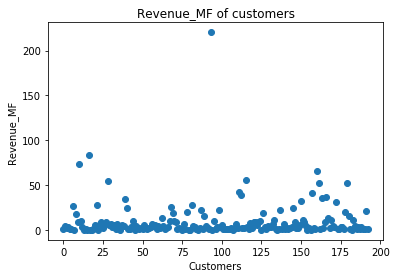

In [329]:
plt.scatter(range(len(Revenue_MF)), Revenue_MF)
plt.title("Revenue_MF of customers")
plt.ylabel('Revenue_MF'), plt.xlabel('Customers')
plt.show()

The distribution of Revenue_MF values shows a significant outlier (with revenue > 100). This outlier will be removed before calculating the mean.

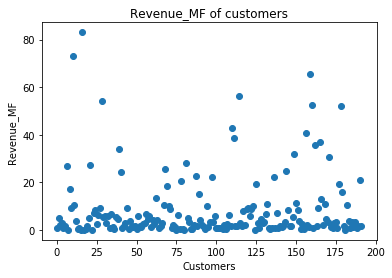

In [330]:
# Remove outlier
Revenue_MF = Revenue_MF[Revenue_MF<100]
plt.scatter(range(len(Revenue_MF)), Revenue_MF)
plt.title("Revenue_MF of customers")
plt.ylabel('Revenue_MF'), plt.xlabel('Customers')
plt.show()

In [331]:
Mean_Revenue_MF = Revenue_MF.mean()
Mean_Revenue_MF

8.566936383869791

## V.2 Revenue_CC

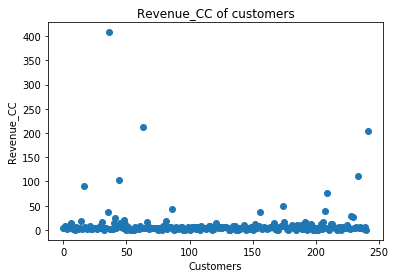

242

In [332]:
plt.scatter(range(len(Revenue_CC)), Revenue_CC)
plt.title("Revenue_CC of customers")
plt.ylabel('Revenue_CC'), plt.xlabel('Customers')
plt.show()
len(Revenue_CC)

There are 7 customers with revenue > 50 which represent only 2% of customers. These customers will be removed before calculating the mean that will be used as target revenue for customers who buy a Credit Card.

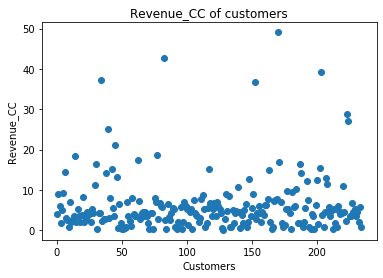

In [333]:
# Remove outliers
Revenue_CC = Revenue_CC[Revenue_CC<=50]
plt.scatter(range(len(Revenue_CC)), Revenue_CC)
plt.title("Revenue_CC of customers")
plt.ylabel('Revenue_CC'), plt.xlabel('Customers')
plt.show()

In [334]:
Mean_Revenue_CC = Revenue_CC.mean()
Mean_Revenue_CC

6.061472644412766

## V.3 Revenue_CL

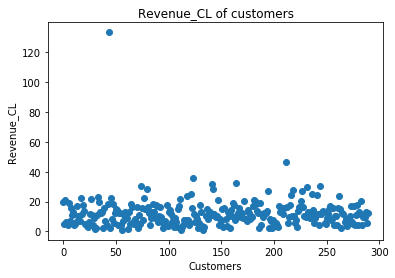

235

In [335]:
plt.scatter(range(len(Revenue_CL)), Revenue_CL)
plt.title("Revenue_CL of customers")
plt.ylabel('Revenue_CL'), plt.xlabel('Customers')
plt.show()
len(Revenue_CC)

There are 2 customers with revenue > 40 which will be considered as outliers and thus removed before mean calculation.

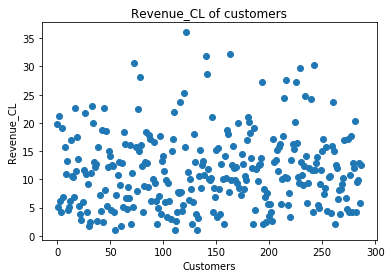

In [336]:
# Remove outliers
Revenue_CL = Revenue_CL[Revenue_CL<=40]
plt.scatter(range(len(Revenue_CL)), Revenue_CL)
plt.title("Revenue_CL of customers")
plt.ylabel('Revenue_CL'), plt.xlabel('Customers')
plt.show()

In [337]:
Mean_Revenue_CL = Revenue_CL.mean()
Mean_Revenue_CL

11.502850942652778

## V.4 Set The Revenue Values Of The Test Data

In [ ]:
dmo_test.loc[:, 'Revenue_MF'] = Mean_Revenue_MF
dmo_test.loc[:, 'Revenue_CC'] = Mean_Revenue_CC
dmo_test.loc[:, 'Revenue_CL'] = Mean_Revenue_CL
final_features = ['Client', 'Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL']
output_data = dmo_test[final_features]
output_data

# VI. Results

## VI.1 Which clients have higher propensity to buy consumer loan?
The top 5 clients in terms of propensity to buy a consumer loan are : 1373, 389, 1569, 1455, 350.
Important features for determining their propensity are :

In [339]:
salecl_features

['NetCA_flow',
 'TransactionsCred_CA',
 'VolumeDebCash_Card',
 'VolumeDebCashless_Card',
 'VolumeDeb_PaymentOrder',
 'TransactionsDeb_CA',
 'TransactionsDebCash_Card',
 'TransactionsDeb_PaymentOrder',
 'Count_MF',
 'ActBal_CA',
 'ActBal_SA',
 'ActBal_MF',
 'Age',
 'Tenure']

In [340]:
# Sort the output_data by Sale_CL in descending order
output_data = output_data.sort_values('Sale_CL', ascending=False)

# Save clients' propensity to buy a CL to csv 
output_data[['Client', 'Sale_CL']].to_csv('CL_clients_propensity.csv', sep=',', mode='w', header=True, index=False)
output_data.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
891,1569,0.896614,0.098262,0.992531,8.566936,6.061473,11.502851
1138,878,0.763547,0.124524,0.979731,8.566936,6.061473,11.502851
56,350,0.127691,0.049869,0.959978,8.566936,6.061473,11.502851
653,1455,0.001608,0.412436,0.956300,8.566936,6.061473,11.502851
258,1082,0.148788,0.128311,0.953686,8.566936,6.061473,11.502851


## VI.2 Which clients have higher propensity to buy credit card?

The top 5 clients in terms of propensity to buy a credit card are : 352, 197, 1414, 1455, 587.
Important features for determining their propensity are :

In [341]:
salecc_features

['NetCA_flow',
 'TransactionsCred_CA',
 'VolumeDebCash_Card',
 'VolumeDebCashless_Card',
 'VolumeDeb_PaymentOrder',
 'TransactionsDeb_CA',
 'TransactionsDebCash_Card',
 'TransactionsDeb_PaymentOrder',
 'ActBal_CA',
 'ActBal_SA',
 'Age',
 'Tenure']

In [342]:
# Sort the output_data by Sale_CC in descending order
output_data = output_data.sort_values('Sale_CC', ascending=False)

# Save clients' propensity to buy a CC to csv 
output_data[['Client', 'Sale_CC']].to_csv('CC_clients_propensity.csv', sep=',', mode='w', header=True, index=False)
output_data.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
631,352,0.041800,0.996335,0.193378,8.566936,6.061473,11.502851
222,197,0.082357,0.996156,0.007120,8.566936,6.061473,11.502851
634,389,0.625394,0.981284,0.944821,8.566936,6.061473,11.502851
297,535,0.010146,0.977441,0.460171,8.566936,6.061473,11.502851
810,19,0.102194,0.976839,0.115520,8.566936,6.061473,11.502851


## VI.3 Which clients have higher propensity to buy mutual fund?

The top 5 clients in terms of propensity to buy a mutual fund are : 506, 766, 110, 785, 878. Important features for determining their propensity are :

In [343]:
salemf_features

['NetCA_flow',
 'TransactionsCred_CA',
 'VolumeDebCash_Card',
 'VolumeDebCashless_Card',
 'VolumeDeb_PaymentOrder',
 'TransactionsDeb_CA',
 'TransactionsDebCash_Card',
 'TransactionsDeb_PaymentOrder',
 'Count_MF',
 'ActBal_CA',
 'ActBal_SA',
 'Age',
 'Tenure']

In [344]:
# Sort the output_data by Sale_MF in descending order
output_data = output_data.sort_values('Sale_MF', ascending=False)

# Save clients' propensity to buy a MF to csv 
output_data[['Client', 'Sale_MF']].to_csv('MF_clients_propensity.csv', sep=',', mode='w', header=True, index=False)
output_data.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
99,506,0.995490,0.001119,0.052242,8.566936,6.061473,11.502851
498,766,0.950344,0.144887,0.007608,8.566936,6.061473,11.502851
891,1569,0.896614,0.098262,0.992531,8.566936,6.061473,11.502851
294,110,0.880411,0.084372,0.007860,8.566936,6.061473,11.502851
218,200,0.776202,0.019483,0.062965,8.566936,6.061473,11.502851


## VI.4 Clients to target and offer
- We will create a composite score or expected revenue for each customer per offer by mutliplying the propensity and mean revenue expected. <br>
**Assumption : Higher revenue is generated from clients with higher propensity.**<br>
- Then we will choose the highest expected revenue among the three and the corresponding offer as best offer for each client.<br>
- Finally, we will sort the clients by Expected Revenue in descending order to identify the top 100 customers to be targeted.<br>
We will use the Expected Revenue and Best Offer columns as output.<br><br>
**97 clients to be targeted with Consumer Loan offer and 3 clients with Mutual Fund offer.**

In [345]:
output_data.loc[:, 'Score_MF'] = output_data.loc[:, 'Sale_MF'] * output_data.loc[:, 'Revenue_MF']
output_data.loc[:, 'Score_CC'] = output_data.loc[:, 'Sale_CC'] * output_data.loc[:, 'Revenue_CC']
output_data.loc[:, 'Score_CL'] = output_data.loc[:, 'Sale_CL'] * output_data.loc[:, 'Revenue_CL']

output_data

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Score_MF,Score_CC,Score_CL
99,506,0.995490,0.001119,0.052242,8.566936,6.061473,11.502851,8.528304,0.006783,0.600928
498,766,0.950344,0.144887,0.007608,8.566936,6.061473,11.502851,8.141536,0.878231,0.087512
891,1569,0.896614,0.098262,0.992531,8.566936,6.061473,11.502851,7.681237,0.595615,11.416936
294,110,0.880411,0.084372,0.007860,8.566936,6.061473,11.502851,7.542426,0.511417,0.090410
218,200,0.776202,0.019483,0.062965,8.566936,6.061473,11.502851,6.649670,0.118097,0.724281
...,...,...,...,...,...,...,...,...,...,...
297,535,0.010146,0.977441,0.460171,8.566936,6.061473,11.502851,0.086921,5.924731,5.293282
660,496,0.007331,0.795326,0.558750,8.566936,6.061473,11.502851,0.062802,4.820844,6.427220
488,1414,0.007313,0.160366,0.597100,8.566936,6.061473,11.502851,0.062650,0.972057,6.868355
653,1455,0.001608,0.412436,0.956300,8.566936,6.061473,11.502851,0.013777,2.499970,11.000175


Use the maximum of the three scores of each customer as expected revenue and target this customer with the corresponding offer.

In [346]:
def Compare(row):
    if row['Score_MF'] > row['Score_CC'] and row['Score_MF'] > row['Score_CL']:    # Best offer for this customer is MF
        result = [row['Score_MF'], 'Mutual Fund']
    elif row['Score_CC'] > row['Score_MF'] and row['Score_CC'] > row['Score_CL']:  # Best offer for this customer is CC
        result = [row['Score_CC'], 'Credit Card']
    elif row['Score_CL'] > row['Score_MF'] and row['Score_CL'] > row['Score_CC']:  # Best offer for this customer is CL
        result = [row['Score_CL'], 'Consumer Loan']
    return result

output_data.loc[:,'Expected_Revenue'] = output_data.apply(lambda row:Compare(row)[0], axis=1)
output_data.loc[:,'Best_Offer'] = output_data.apply(lambda row:Compare(row)[1], axis=1)
output_data

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Score_MF,Score_CC,Score_CL,Expected_Revenue,Best_Offer
99,506,0.995490,0.001119,0.052242,8.566936,6.061473,11.502851,8.528304,0.006783,0.600928,8.528304,Mutual Fund
498,766,0.950344,0.144887,0.007608,8.566936,6.061473,11.502851,8.141536,0.878231,0.087512,8.141536,Mutual Fund
891,1569,0.896614,0.098262,0.992531,8.566936,6.061473,11.502851,7.681237,0.595615,11.416936,11.416936,Consumer Loan
294,110,0.880411,0.084372,0.007860,8.566936,6.061473,11.502851,7.542426,0.511417,0.090410,7.542426,Mutual Fund
218,200,0.776202,0.019483,0.062965,8.566936,6.061473,11.502851,6.649670,0.118097,0.724281,6.649670,Mutual Fund
...,...,...,...,...,...,...,...,...,...,...,...,...
297,535,0.010146,0.977441,0.460171,8.566936,6.061473,11.502851,0.086921,5.924731,5.293282,5.924731,Credit Card
660,496,0.007331,0.795326,0.558750,8.566936,6.061473,11.502851,0.062802,4.820844,6.427220,6.427220,Consumer Loan
488,1414,0.007313,0.160366,0.597100,8.566936,6.061473,11.502851,0.062650,0.972057,6.868355,6.868355,Consumer Loan
653,1455,0.001608,0.412436,0.956300,8.566936,6.061473,11.502851,0.013777,2.499970,11.000175,11.000175,Consumer Loan


In [347]:
output_data = output_data.sort_values('Expected_Revenue', ascending=False)
clients_to_target_and_offer = output_data.loc[:,['Client', 'Expected_Revenue', 'Best_Offer']].head(100)
clients_to_target_and_offer['Best_Offer'].value_counts()

Consumer Loan    89
Credit Card       6
Mutual Fund       5
Name: Best_Offer, dtype: int64

In [348]:
# Save output to csv file
clients_to_target_and_offer.to_csv('clients_to_target_and_offer.csv', sep=',', mode='w', header=True, index=False)
clients_to_target_and_offer

,Client,Expected_Revenue,Best_Offer
891,1569,11.416936,Consumer Loan
1138,878,11.269701,Consumer Loan
56,350,11.042480,Consumer Loan
653,1455,11.000175,Consumer Loan
258,1082,10.970112,Consumer Loan
...,...,...,...
1169,504,5.909000,Consumer Loan
293,325,5.864949,Consumer Loan
128,951,5.842941,Credit Card
640,587,5.840939,Credit Card


## VI.5 Expected revenue with this strategy
- **The expected revenue with this strategy is : 758.8**

In [349]:
clients_to_target_and_offer['Expected_Revenue'].sum()

758.8225772716901

# Conclusion

The objective of this excercise was to maximize revenue from targeted marketing campaigns with a limited number of clients to target with a specific offer per client. The input data was social-demographical data, products and actual account volumes, inflow/outflow turnovers and actual sales and revenues for 60% of clients.
<br><br>
Feature engineering techniques like imputation for missing values, feature discarding or transformation based on correlations and normalization were applied to prepare the input data dataset for modelling. RandomForest variable selection procedure was applied with suitable variable selection thresholds to significantly reduce the dataset's dimensionality and model complexity.<br><br>
Mutual Fund, Credit Card and Consumer Loan propensity keras neural network models of type Multi-Layer Perceptron with 1 or more hidden layers were trained using important features and had an output layer returning a probability (with sigmoid activation function). Models trained with a binary cross-entropy loss function yielded validation accuracies between 71% and 80% and AUC scores between 51% and 67%.
<br><br>
The Sales propensity for the test data or customers was predicted with the obtained models. The average revenue for each sale type from training data was then considered in the test data as the target revenue, after removing a few outlier customers.
A composite score/expected revenue was calculated for each customer per offer type by multiplying sales propensity/probability and target revenue, with the assumption: **"clients with higher propensity generate higher revenue"**. The maximum of the three composite scores was considered as the expected revenue for each customer and the corresponding offer as the best for targeting the customer, to maximize revenue. The top 100 clients were obtained by ranking on maximum expected revenue per client. Several output csv files were generated :<br>
- CL_clients_propensity.csv : Test clients and their predicted propensity to buy consumer loans<br>
- CC_clients_propensity.csv : Test clients and their predicted propensity to buy credit cards<br>
- MF_clients_propensity.csv : Test clients and their predicted propensity to buy mutual funds<br>
- clients_to_target_and_offer.csv : 100 Test clients to target and corresponding offer to maximize revenue<br><br>
**The expected revenue with this strategy is 758.8**.<br><br>

Furthermore :
- Using a larger balanced dataset could improve sales propensity or revenue modelling accuracy.
- More information on the data required : Can a customer’s tenure be higher than his/her age? Can customers aged less than 15 years for example buy bank products?